✅ Data loaded successfully
Train shape: (7340, 18)
Test shape: (397, 8)
Calendar shape: (13307, 15)

--- Train Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7340 entries, 0 to 7339
Data columns (total 18 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   warehouse               7340 non-null   object        
 1   date                    7340 non-null   datetime64[ns]
 2   orders                  7340 non-null   float64       
 3   holiday_name            218 non-null    object        
 4   holiday                 7340 non-null   int64         
 5   shutdown                7340 non-null   int64         
 6   mini_shutdown           7340 non-null   int64         
 7   shops_closed            7340 non-null   int64         
 8   winter_school_holidays  7340 non-null   int64         
 9   school_holidays         7340 non-null   int64         
 10  blackout                7340 non-null   int64   

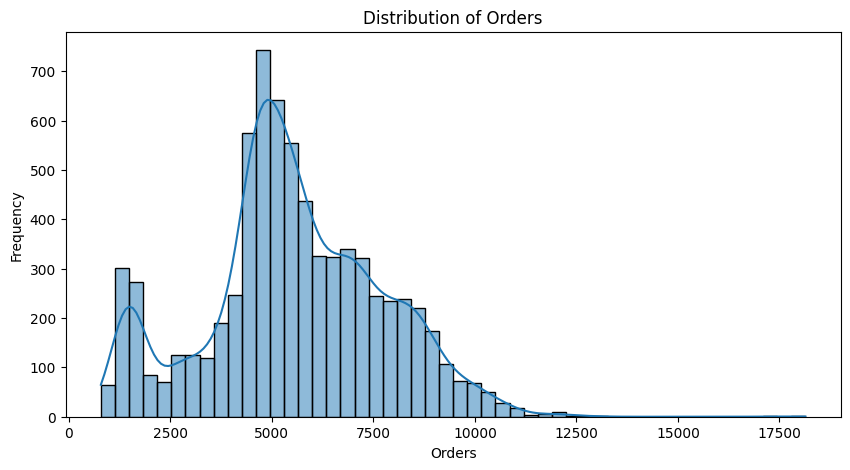

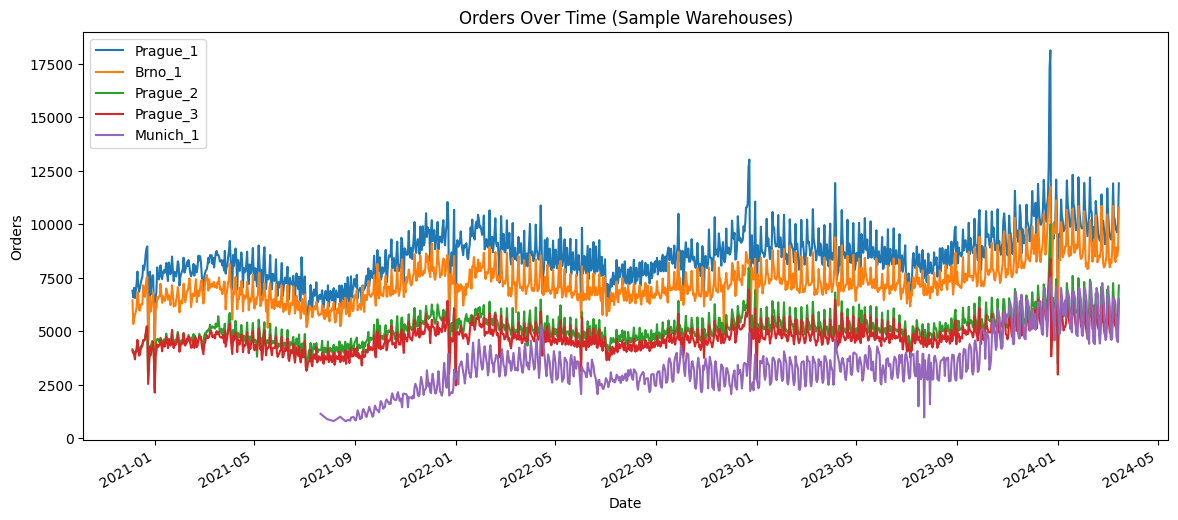

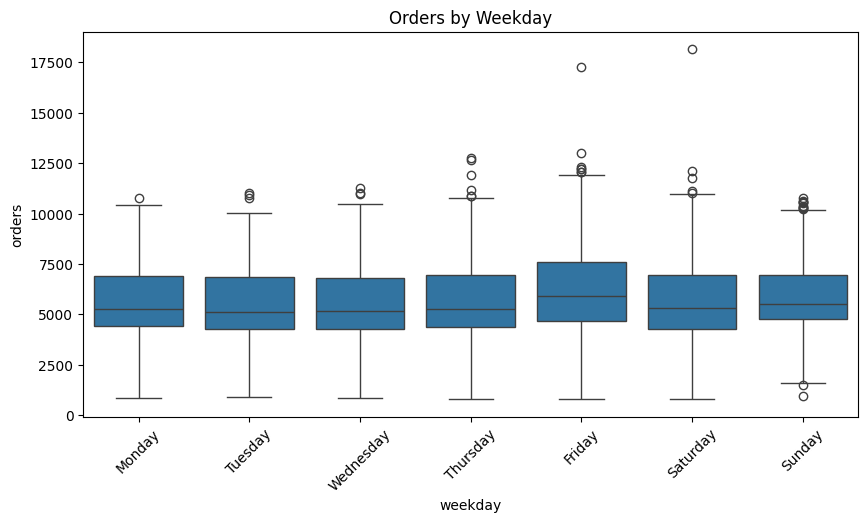

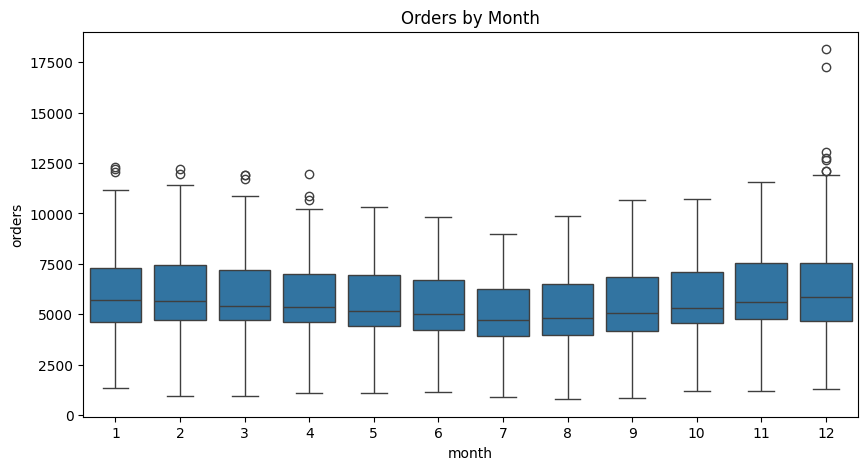

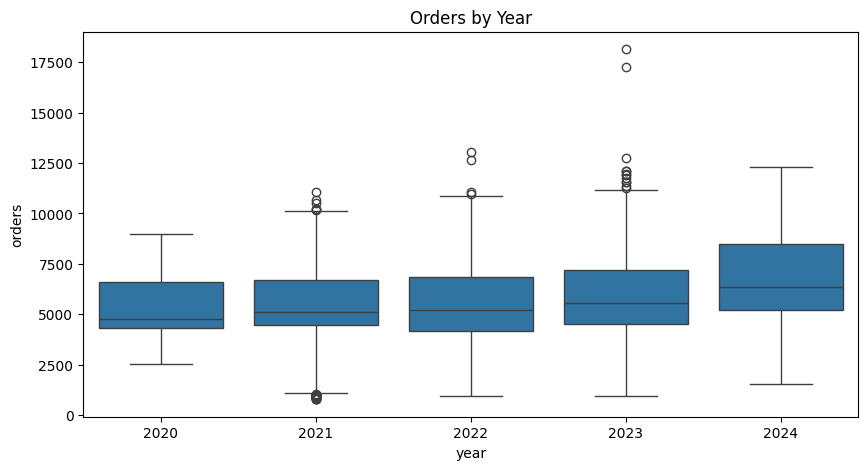

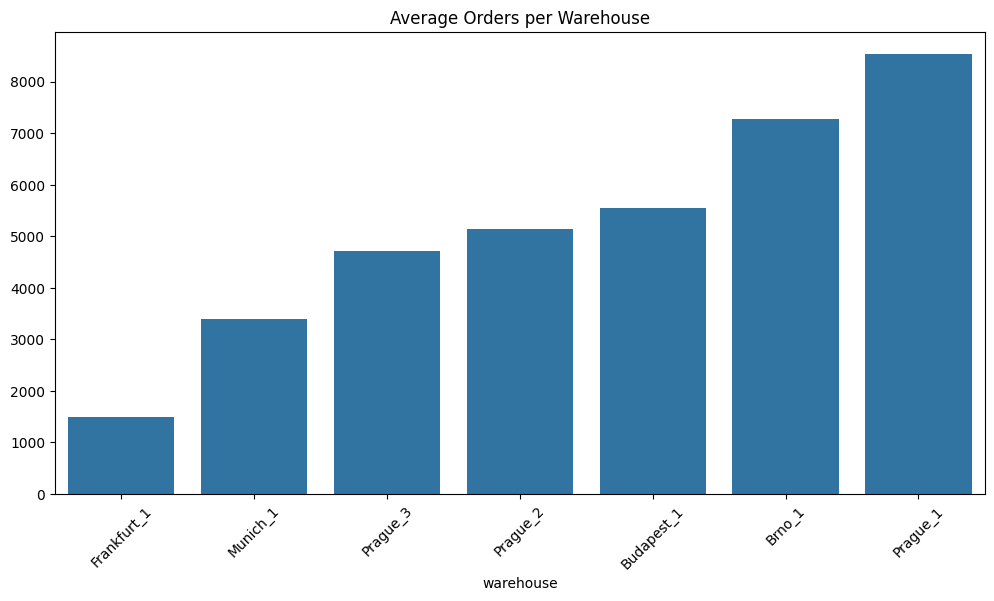

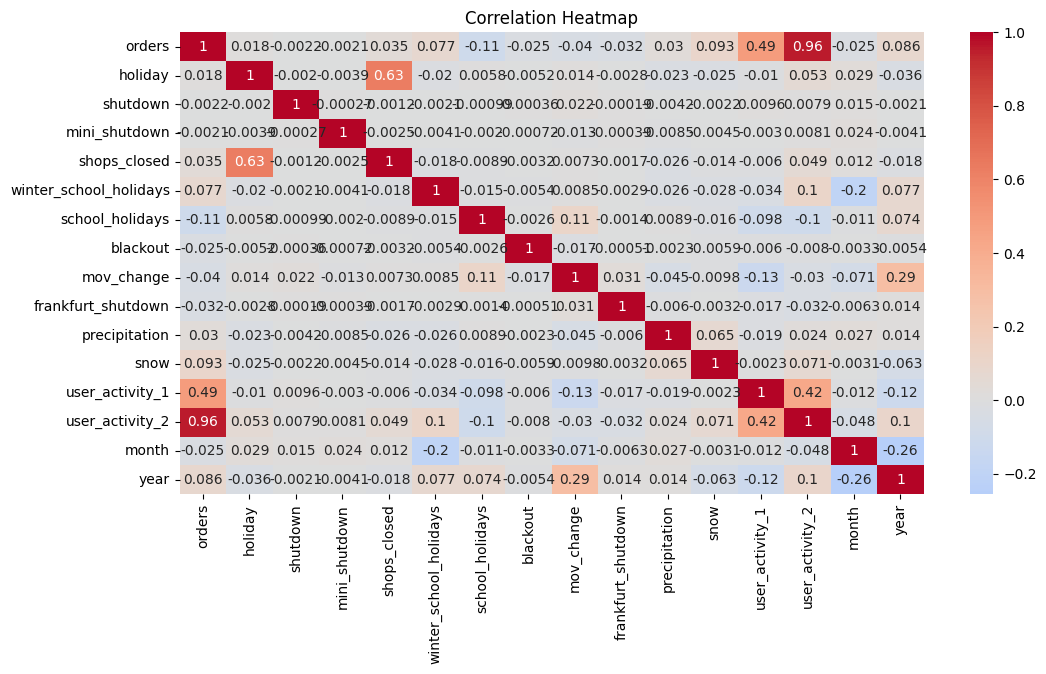

⚠️ No lag features found in dataset

📊 Dataset Summary:
train_shape: (7340, 21)
test_shape: (397, 8)
calendar_shape: (13307, 15)
warehouses: 7
date_range_train: [Timestamp('2020-12-05 00:00:00'), Timestamp('2024-03-15 00:00:00')]
date_range_test: [Timestamp('2024-03-16 00:00:00'), Timestamp('2024-05-15 00:00:00')]
avg_orders: 5535.443869209809
median_orders: 5370.0
max_orders: 18139.0


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

# =========================
# 1. Load Data
# =========================
train = pd.read_csv("../data/forecast/train.csv", parse_dates=["date"])
test = pd.read_csv("../data/forecast/test.csv", parse_dates=["date"])
calendar = pd.read_csv("../data/forecast/train_calendar.csv", parse_dates=["date"])

print("✅ Data loaded successfully")
print(f"Train shape: {train.shape}")
print(f"Test shape: {test.shape}")
print(f"Calendar shape: {calendar.shape}")

# =========================
# 2. Basic Info
# =========================
print("\n--- Train Info ---")
print(train.info())
print(train.describe(include="all").T)

print("\n--- Test Info ---")
print(test.info())

# =========================
# 3. Missing Values
# =========================
def missing_report(df, name="Dataset"):
    missing = df.isnull().sum()
    missing = missing[missing > 0].sort_values(ascending=False)
    if missing.empty:
        print(f"✅ No missing values in {name}")
    else:
        print(f"\n🔎 Missing values in {name}:\n")
        print(missing)

missing_report(train, "Train")
missing_report(test, "Test")
missing_report(calendar, "Calendar")

# =========================
# 4. Target Distribution
# =========================
plt.figure(figsize=(10,5))
sns.histplot(train["orders"], bins=50, kde=True)
plt.title("Distribution of Orders")
plt.xlabel("Orders")
plt.ylabel("Frequency")
plt.show()

# =========================
# 5. Time Series Trends
# =========================
plt.figure(figsize=(14,6))
for wh in train["warehouse"].unique()[:5]:  # plot for first 5 warehouses
    subset = train[train["warehouse"] == wh]
    subset.groupby("date")["orders"].sum().plot(label=wh)
plt.legend()
plt.title("Orders Over Time (Sample Warehouses)")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.show()

# =========================
# 6. Seasonality & Calendar Features
# =========================
# Add time features
train["weekday"] = train["date"].dt.day_name()
train["month"] = train["date"].dt.month
train["year"] = train["date"].dt.year

# Weekday pattern
plt.figure(figsize=(10,5))
sns.boxplot(x="weekday", y="orders", data=train, order=[
    "Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
plt.title("Orders by Weekday")
plt.xticks(rotation=45)
plt.show()

# Month pattern
plt.figure(figsize=(10,5))
sns.boxplot(x="month", y="orders", data=train)
plt.title("Orders by Month")
plt.show()

# Yearly trend
plt.figure(figsize=(10,5))
sns.boxplot(x="year", y="orders", data=train)
plt.title("Orders by Year")
plt.show()


# =========================
# 7. Warehouse-level Analysis
# =========================
plt.figure(figsize=(12,6))
warehouse_means = train.groupby("warehouse")["orders"].mean().sort_values()
sns.barplot(x=warehouse_means.index, y=warehouse_means.values)
plt.title("Average Orders per Warehouse")
plt.xticks(rotation=45)
plt.show()

# =========================
# 8. Correlation Analysis
# =========================
numeric_cols = train.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12,6))
sns.heatmap(train[numeric_cols].corr(), annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

# =========================
# 9. Lag Features vs Orders (if present)
# =========================
lag_cols = [c for c in train.columns if "lag" in c or "rmean" in c]
if lag_cols:
    print(f"\n📌 Found lag features: {lag_cols}")
    for col in lag_cols[:5]:
        plt.figure(figsize=(8,4))
        sns.scatterplot(x=train[col], y=train["orders"], alpha=0.3)
        plt.title(f"Orders vs {col}")
        plt.show()
else:
    print("⚠️ No lag features found in dataset")

# =========================
# 10. Save Summary
# =========================
summary = {
    "train_shape": train.shape,
    "test_shape": test.shape,
    "calendar_shape": calendar.shape,
    "warehouses": train["warehouse"].nunique(),
    "date_range_train": [train["date"].min(), train["date"].max()],
    "date_range_test": [test["date"].min(), test["date"].max()],
    "avg_orders": train["orders"].mean(),
    "median_orders": train["orders"].median(),
    "max_orders": train["orders"].max()
}
print("\n📊 Dataset Summary:")
for k,v in summary.items():
    print(f"{k}: {v}")



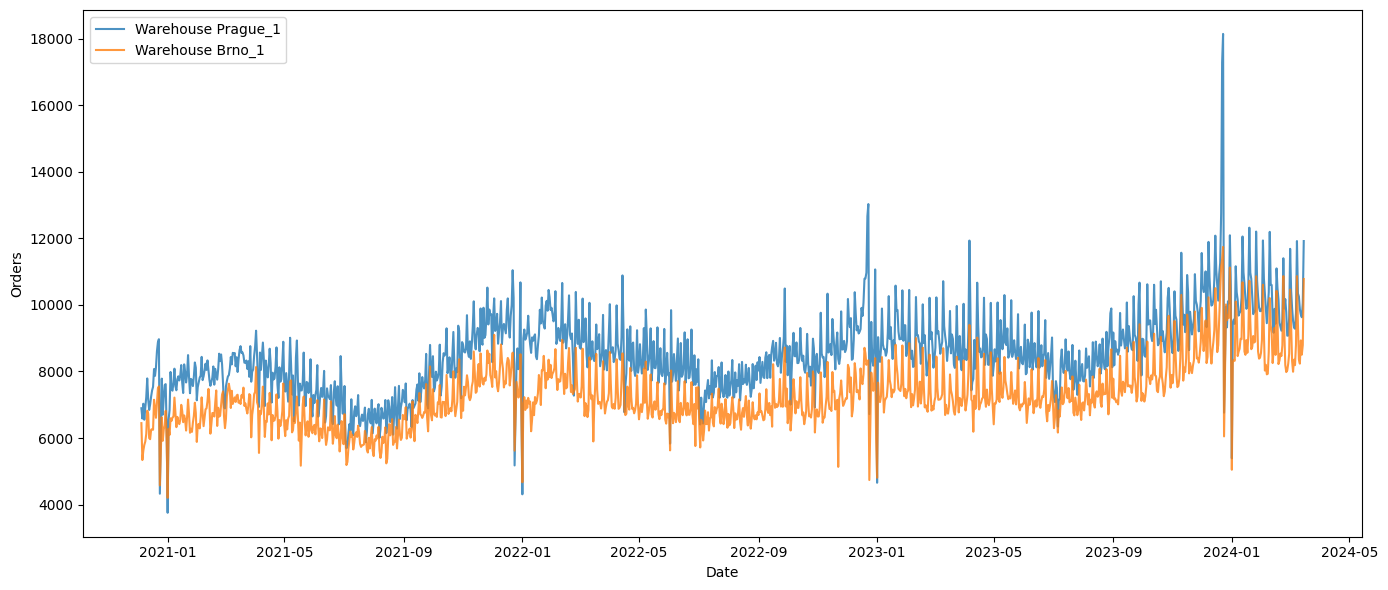

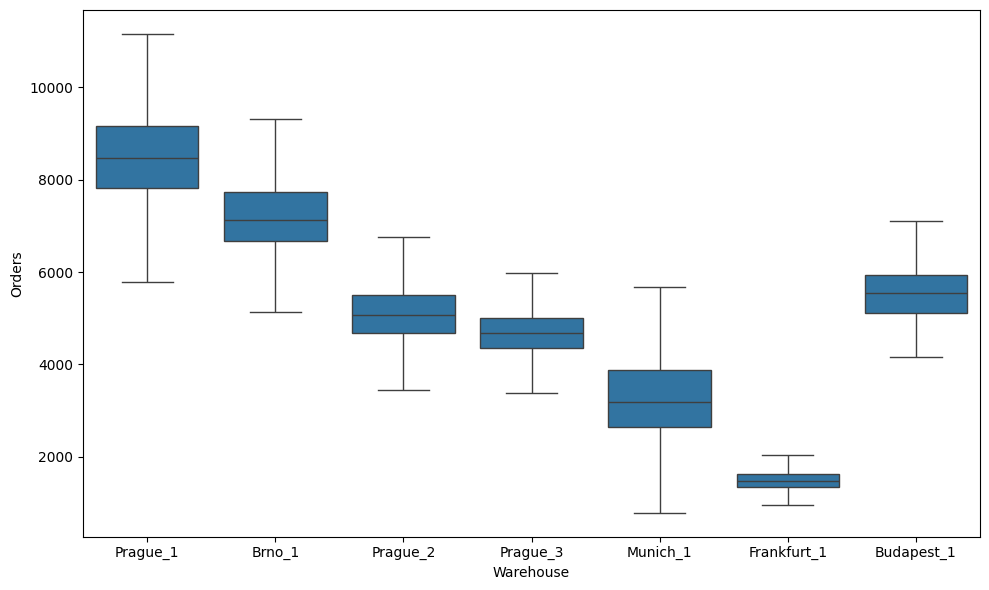

In [5]:
# ==============================
# Figure C1. Demand Trends Across Warehouses
# ==============================
plt.figure(figsize=(14,6))

# Select a couple of warehouses (example: first two alphabetically)
top_warehouses = train["warehouse"].unique()[:2]
for w in top_warehouses:
    subset = train[train["warehouse"] == w]
    plt.plot(subset["date"], subset["orders"], label=f"Warehouse {w}", alpha=0.8)

# plt.title("Figure C1. Demand Trends Across Warehouses", fontsize=14)
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.tight_layout()
plt.show()

# ==============================
# Figure C2. Distribution of Daily Demand
# ==============================
plt.figure(figsize=(10,6))
sns.boxplot(x="warehouse", y="orders", data=train, showfliers=False)

# plt.title("Figure C2. Distribution of Daily Demand", fontsize=14)
plt.xlabel("Warehouse")
plt.ylabel("Orders")
plt.tight_layout()
plt.show()